# MSLS and ILS

## Imports

In [36]:
import numpy as np
np.random.seed(42)
import pandas as pd
import math
import seaborn as sns
import random
random.seed(42)
import time
import heapq
from sortedcontainers import SortedList

import matplotlib.pyplot as plt
import matplotlib.cm as cm

In [37]:
TSPA_PATH = "../data/TSPA.csv"
TSPB_PATH = "../data/TSPB.csv"

In [38]:
df = pd.read_csv(TSPA_PATH, sep=";", header=None)
df.columns = ["x", "y", "val"]
df

,x,y,val
0,1355,1796,496
1,2524,387,414
2,2769,430,500
3,3131,1199,1133
4,661,87,903
...,...,...,...
195,189,1151,1145
196,3688,759,727
197,973,984,1637
198,910,1383,1255


In [39]:
def math_round(n):
    '''
    Mathematically rounds up to the nearest integer, always rounds up for 0.5

    ParametersL
    n: floating point number to round
    '''
    if n - math.floor(n) < 0.5:
        return math.floor(n)
    return math.ceil(n)

In [40]:
def plot_nodes_with_lines(df, connections=None):
    """
    Plots nodes with optional lines connecting them, using a color scale to represent values.
    
    Parameters:
    df: DataFrame of nodes, each with 'x', 'y', and 'val'.
    connections: list of node indices in the DataFrame to connect in order.
    """
    plt.figure(figsize=(14, 7))
    norm = plt.Normalize(vmin=df.val.min(), vmax=df.val.max())
    colors = cm.Reds(norm(df.val))
    scatter = plt.scatter(df.x, df.y, c=df.val, cmap='Reds', s=100, edgecolors='black')

    if connections is not None:
        for start, end in zip(connections[:-1], connections[1:]):
            plt.plot([df.x[start], df.x[end]], [df.y[start], df.y[end]], color='blue')
        plt.plot([df.x[connections[-1]], df.x[connections[0]]], [df.y[connections[-1]], df.y[connections[0]]], color='blue')
    cbar = plt.colorbar(scatter)
    cbar.set_label('Node Cost')

    plt.xlabel('X')
    plt.ylabel('Y')
    title = 'Nodes with Color-Scaled Values' if connections is None else 'Nodes with Values and Connections'
    plt.title(title)
    plt.grid(False)
    plt.show()


def get_distance_matrix(df, distance_function):
    """
    Calculates the distance matrix for a set of nodes using the given distance function.

    Parameters:
    nodes: DataFrame of nodes, each with 'x', 'y', and 'val'.
    distance_function: function that takes two points (x1, y1) and (x2, y2) and returns the distance.

    Returns:
    A 2D numpy array representing the distance matrix.
    """
    positions = df[["x", "y"]]
    num_nodes = len(positions)
    distance_matrix = np.zeros((num_nodes, num_nodes), dtype=np.int64)

    for i in range(num_nodes):
        for j in range(i, num_nodes):
            dist = round(distance_function(positions.iloc[i], positions.iloc[j]))
            distance_matrix[i, j] = dist
            distance_matrix[j, i] = dist

    return distance_matrix


def calculate_score(solution, matrix, weights):
    '''
    Calculates solution score based on the matrix of distances and provided weights array.

    Parameters:
    solution: List or array of the solution
    matrix: Numpy array with node distances (2D)
    weights: Numpy array with node weights (1D - vector)
    '''
    score = 0
    for i in range(len(solution)-1):
        node_1 = solution[i]
        node_2 = solution[i+1]
        score += (matrix[node_1][node_2] + weights[node_1])
    node_1 = solution[-1]
    node_2 = solution[0]
    score += (matrix[node_1][node_2] + weights[node_1])
    return score

def euclidean_distance(point1, point2):
    return np.linalg.norm(point1 - point2)

In [41]:
def random_solution(distance_matrix, weights, start_node):
    '''
    Returns a random solution to the TSP problem based on the provided distance matrix.

    Parameters:
    distance_matrix: numpy.array containing distances between the nodes.
    weights: numpy.array containing the weights associated with each node.
    start_node: int, the index of the node from which the cycle starts.
    '''

    remaining_nodes = list(range(len(distance_matrix)))
    remaining_nodes.remove(start_node)
    np.random.shuffle(remaining_nodes)
    solution = [start_node] + remaining_nodes[:len(distance_matrix)//2 - 1]
    score = calculate_score(solution, distance_matrix, weights)
    return solution, score

In [42]:
distance_matrix = get_distance_matrix(df, euclidean_distance)
pd.DataFrame(distance_matrix)

,0,1,2,3,4,5,6,7,8,9,...,190,191,192,193,194,195,196,197,198,199
0,0,1831,1966,1874,1845,1097,1658,2297,2193,1364,...,1977,746,1414,993,1527,1333,2553,897,607,1100
1,1831,0,249,1014,1887,1985,802,1872,1270,1027,...,2173,2104,2213,2215,1016,2457,1222,1662,1897,2600
2,1966,249,0,850,2136,2209,1050,1698,1066,981,...,2421,2301,2447,2426,1264,2679,976,1880,2089,2796
3,1874,1014,850,0,2709,2513,1715,858,344,512,...,2976,2442,2809,2632,1861,2942,710,2169,2229,2907
4,1845,1887,2136,2709,0,888,1091,3487,3036,2396,...,288,1352,780,1214,874,1164,3101,950,1320,1632
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,1333,2457,2679,2942,1164,473,1834,3537,3286,2486,...,1087,587,384,342,1587,0,3521,802,757,523
196,2553,1222,976,710,3101,3068,2023,1124,517,1212,...,3384,3063,3338,3231,2227,3521,0,2724,2847,3545
197,897,1662,1880,2169,950,345,1113,2824,2513,1741,...,1085,529,649,563,890,802,2724,0,404,987
198,607,1897,2089,2229,1320,497,1462,2785,2569,1752,...,1409,216,807,419,1260,757,2847,404,0,708


In [43]:
weights = df.val.to_numpy()
weights[:2]

array([496, 414], dtype=int64)

## Random

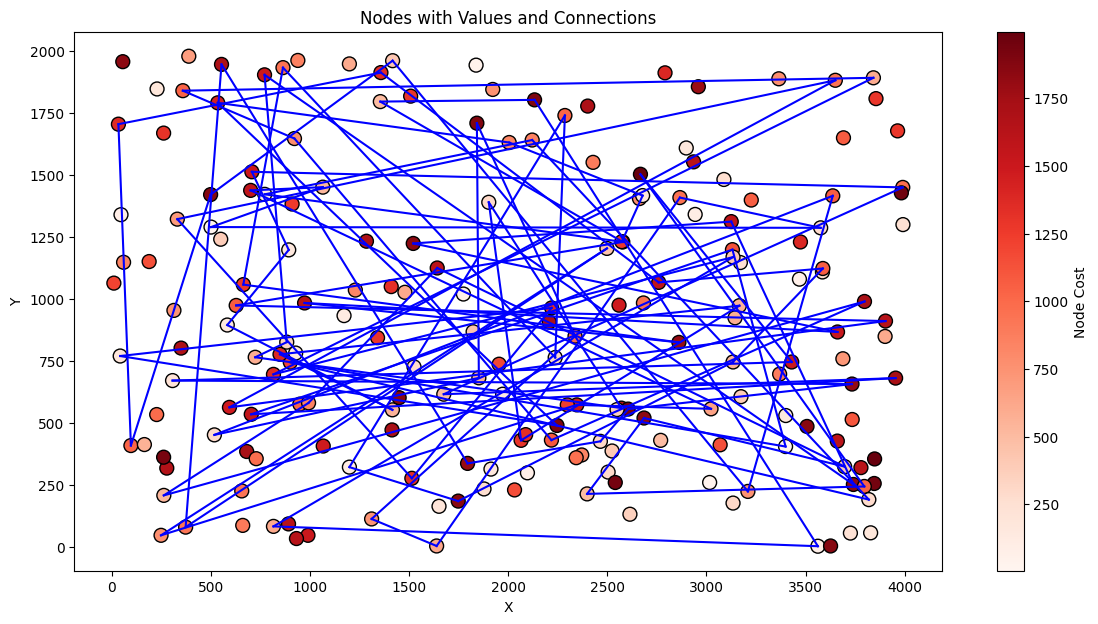

273509


In [44]:
start_solution, start_score = random_solution(distance_matrix, weights, start_node = 0)
plot_nodes_with_lines(df, start_solution)
print(start_score)

## Delta Steepest Search and Steepest Search

In [45]:
def update_score(solution, score, node, insert_location, matrix, weights):
    '''
    Updates the total score after inserting a node at a specified location in the solution. 

    Parameters:
    solution: List of nodes representing the current cycle.
    score: The current total score (cost) of the cycle before the node is inserted.
    node: int, the node to be inserted into the solution.
    insert_location: int, the index at which the node will be inserted.
    matrix: numpy.array containing distances between nodes.
    weights: numpy.array containing the weights associated with each node.
    '''
    node_before = solution[insert_location - 1]
    node_after = solution[insert_location]
    score -= matrix[node_before][node_after]
    score += matrix[node_before][node] + matrix[node][node_after] + weights[node]
    return score


def update_score_inter(score, solution, cycle_position, relative_node_position, remaining_nodes, num_cycle_nodes, distance_matrix, weights):
    '''
    Calculates the score after changing the node with an outside node in remaining_nodes. Only used when a new move appears.
    '''
    node_1 = solution[cycle_position]
    node_2 = remaining_nodes[relative_node_position]
    node_before = solution[cycle_position - 1]
    node_after = solution[(cycle_position + 1) % num_cycle_nodes]
    score -= distance_matrix[node_1][node_before]
    score -= distance_matrix[node_1][node_after]
    score -= weights[node_1]
    score += distance_matrix[node_2][node_before]
    score += distance_matrix[node_2][node_after]
    score += weights[node_2]
    return score

def update_score_inter_edge(temp_score, solution, cycle_position, any_node_position, num_cycle_nodes, distance_matrix):
    '''
    Calculates the score after changing the solution by exchanging edges. Only used when a new move appears.
    '''
    temp_score -= distance_matrix[solution[cycle_position]][solution[cycle_position+1]]
    temp_score -= distance_matrix[solution[any_node_position]][solution[(any_node_position + 1) % num_cycle_nodes]]

    temp_score += distance_matrix[solution[cycle_position]][solution[any_node_position]]
    temp_score += distance_matrix[solution[cycle_position+1]][solution[(any_node_position + 1) % num_cycle_nodes]]
    return temp_score

def node_intra_change_steepest_fast(move_score, score, solution, cycle_position, relative_node_position, remaining_nodes, solution_set, remaining_nodes_set, solution_index, remaining_nodes_index):
    '''
    Calculates the new solution and score after applying a move by exchanging node with a node from remaining_nodes. Also updates indexes and sets.
    '''
    solution_set.remove(solution[cycle_position])
    solution_set.add(remaining_nodes[relative_node_position])
    remaining_nodes_set.add(solution[cycle_position])
    remaining_nodes_set.remove(remaining_nodes[relative_node_position])
    solution_index[remaining_nodes[relative_node_position]] = cycle_position
    remaining_nodes_index[solution[cycle_position]] = relative_node_position
    solution[cycle_position], remaining_nodes[relative_node_position] = remaining_nodes[relative_node_position], solution[cycle_position]
    return score + move_score, solution, remaining_nodes, solution_set, remaining_nodes_set, solution_index, remaining_nodes_index

def edge_inter_change_steepest_fast(move_score, score, solution, cycle_position, any_node_position, solution_index):
    '''
    Calculates the new solution and score after applying a move by exchanging edges. Also updates indexes and sets.
    '''
    solution[cycle_position+1:any_node_position+1] = solution[cycle_position+1:any_node_position+1][::-1]
    for i in range(cycle_position + 1, any_node_position + 1):
        solution_index[solution[i]] = i
    return score + move_score, solution, solution_index

def get_initial_moves(solution, cycle_positions, remaining_positions, num_cycle_nodes, score, remaining_nodes, distance_matrix, weights):
    '''
    Produces the initial moves.
    '''
    moves = SortedList()
    already_added_inter = set()
    already_added_edges = set()

    for cycle_position in cycle_positions:
        for relative_node_position in range(len(remaining_positions)):
            temp_score = update_score_inter(score, solution, cycle_position, relative_node_position, remaining_nodes, num_cycle_nodes, distance_matrix, weights)
            move_score = temp_score - score
            node_before = solution[cycle_position - 1]
            node_after = solution[(cycle_position + 1) % num_cycle_nodes]
            already_added_inter.add((solution[cycle_position], remaining_nodes[relative_node_position], node_before, node_after))
            if move_score >= 0:
                continue
            moves.add((move_score, (solution[cycle_position], remaining_nodes[relative_node_position], node_before, node_after), 0)) # 0 for intra

        for any_node_position in range(cycle_position + 2, num_cycle_nodes):
            if (cycle_position == 0 and any_node_position == num_cycle_nodes - 1):
                continue
            temp_score = update_score_inter_edge(score, solution, cycle_position, any_node_position, num_cycle_nodes, distance_matrix)
            move_score = temp_score - score
            node_context_1 = solution[(cycle_position + 1) % num_cycle_nodes]
            node_context_2 = solution[(any_node_position + 1) % num_cycle_nodes]
            already_added_edges.add((solution[cycle_position], solution[any_node_position], node_context_1, node_context_2))
            if move_score >= 0:
                continue
            moves.add((move_score, (solution[cycle_position], solution[any_node_position], node_context_1, node_context_2), 1)) # 1 for inter

    return moves, already_added_inter, already_added_edges

def update_moves_intra(score, solution, moves, already_added_inter, already_added_edges, cycle_position, remaining_positions, remaining_nodes, num_cycle_nodes, distance_matrix, weights):
    '''
    Updates moves after an echange of nodes.
    '''
    for relative_node_position in range(len(remaining_positions)):
        prev_node = solution[cycle_position - 1]
        next_node = solution[(cycle_position + 1) % num_cycle_nodes]
        if (solution[cycle_position], remaining_nodes[relative_node_position], prev_node, next_node) in already_added_inter:
            continue
        temp_score = update_score_inter(score, solution, cycle_position, relative_node_position, remaining_nodes, num_cycle_nodes, distance_matrix, weights)
        move_score = temp_score - score
        already_added_inter.add((solution[cycle_position], remaining_nodes[relative_node_position], prev_node, next_node))
        if move_score >= 0:
            continue
        moves.add((move_score, (solution[cycle_position], remaining_nodes[relative_node_position], prev_node, next_node), 0))

    for any_node_position in range(cycle_position + 2, num_cycle_nodes):
        if (cycle_position == 0 and any_node_position == num_cycle_nodes - 1):
            continue
        node_context_1 = solution[(cycle_position + 1) % num_cycle_nodes]
        node_context_2 = solution[(any_node_position + 1) % num_cycle_nodes]
        if (solution[cycle_position], solution[any_node_position], node_context_1, node_context_2) in already_added_edges:
            continue
        temp_score = update_score_inter_edge(score, solution, cycle_position, any_node_position, num_cycle_nodes, distance_matrix)
        move_score = temp_score - score
        already_added_edges.add((solution[cycle_position], solution[any_node_position], node_context_1, node_context_2))
        if move_score >= 0:
            continue
        moves.add((move_score, (solution[cycle_position], solution[any_node_position], node_context_1, node_context_2), 1))
        
    return moves, already_added_inter, already_added_edges

def update_moves_inter_edge(score, cycle_positions, solution, moves, num_cycle_nodes, distance_matrix, remaining_nodes, already_added_inter, already_added_edges, remaining_positions, weights):
    '''
    Updates the moves after an exchange of edges.
    '''
    for cycle_position in cycle_positions:
        for any_node_position in range(cycle_position + 2, num_cycle_nodes):
            if (cycle_position == 0 and any_node_position == num_cycle_nodes - 1):
                continue
            node_context_1 = solution[(cycle_position + 1) % num_cycle_nodes]
            node_context_2 = solution[(any_node_position + 1) % num_cycle_nodes]
            if (solution[cycle_position], solution[any_node_position], node_context_1, node_context_2) in already_added_edges:
                continue
            temp_score = update_score_inter_edge(score, solution, cycle_position, any_node_position, num_cycle_nodes, distance_matrix)
            move_score = temp_score - score
            already_added_edges.add((solution[cycle_position], solution[any_node_position], node_context_1, node_context_2))
            if move_score >= 0:
                continue
            moves.add((move_score, (solution[cycle_position], solution[any_node_position], node_context_1, node_context_2), 1))

    for cycle_position in cycle_positions:
        for relative_node_position in range(len(remaining_positions)):
            prev_node = solution[cycle_position - 1]
            next_node = solution[(cycle_position + 1) % num_cycle_nodes]
            if (solution[cycle_position], remaining_nodes[relative_node_position], prev_node, next_node) in already_added_inter:
                continue
            temp_score = update_score_inter(score, solution, cycle_position, relative_node_position, remaining_nodes, num_cycle_nodes, distance_matrix, weights)
            move_score = temp_score - score
            already_added_inter.add((solution[cycle_position], remaining_nodes[relative_node_position], prev_node, next_node))
            if move_score >= 0:
                continue
            moves.add((move_score, (solution[cycle_position], remaining_nodes[relative_node_position], prev_node, next_node), 0))

    return moves, already_added_inter, already_added_edges

def init_index_dict(values):
    '''
    Creates a dictionary of of indexes for each value.
    '''
    index_dict = {}
    for i in range(len(values)):
        index_dict[values[i]] = i
    return index_dict

def deltas_steepest_local_search_edges(solution, score, distance_matrix, weights):
    num_cycle_nodes = len(solution)
    all_node_positions = [i for i in range(len(weights))]
    cycle_positions = [i for i in range(num_cycle_nodes)]
    remaining_nodes = list(set(all_node_positions) - set(solution))
    remaining_positions = list(set(all_node_positions) - set(cycle_positions))
    solution_set = set(solution)
    remaining_nodes_set = set(remaining_nodes)
    solution_index = init_index_dict(solution)
    remaining_nodes_index = init_index_dict(remaining_nodes)

    moves, already_added_inter, already_added_edges = get_initial_moves(solution, cycle_positions, remaining_positions, num_cycle_nodes, score, remaining_nodes, distance_matrix, weights)
    while True:
        i = 0
        while i < len(moves):
            move_score, move, inter = moves[i]
            if not inter:
                cycle_node, any_node, node_before, node_after = move
                if cycle_node not in solution_set or any_node not in remaining_nodes_set:
                    moves.remove(moves[i])
                    already_added_inter.remove(move)
                    continue
                cycle_position = solution_index[cycle_node]
                if node_before != solution[cycle_position - 1] or node_after != solution[(cycle_position + 1) % num_cycle_nodes]:
                    moves.remove(moves[i])
                    already_added_inter.remove(move)
                    continue
                relative_node_position = remaining_nodes_index[any_node]
                score, solution, remaining_nodes, solution_set, remaining_nodes_set, solution_index, remaining_nodes_index = node_intra_change_steepest_fast(move_score, score, solution, cycle_position, relative_node_position, remaining_nodes, solution_set, remaining_nodes_set, solution_index, remaining_nodes_index)
                moves, already_added_inter, already_added_edges = update_moves_intra(score, solution, moves, already_added_inter, already_added_edges, cycle_position, remaining_positions, remaining_nodes, num_cycle_nodes, distance_matrix, weights)
                i = 0
            else:
                if move[0] not in solution_set or move[1] not in solution_set:
                    moves.remove(moves[i])
                    already_added_edges.remove(move)
                    continue
                cycle_node, any_node, node_after_cycle, node_after_any = move
                cycle_position = solution_index[cycle_node]
                any_node_position = solution_index[any_node]
                if cycle_position > any_node_position:
                    i += 1
                    continue # We got turned around ;(
                if node_after_cycle != solution[(cycle_position + 1) % num_cycle_nodes] or node_after_any != solution[(any_node_position + 1) % num_cycle_nodes]:
                    moves.remove(moves[i])
                    already_added_edges.remove(move)
                    continue
                score, solution, solution_index = edge_inter_change_steepest_fast(move_score, score, solution, cycle_position, any_node_position, solution_index)
                moves, already_added_inter, already_added_edges = update_moves_inter_edge(score, cycle_positions, solution, moves, num_cycle_nodes, distance_matrix, remaining_nodes, already_added_inter, already_added_edges, remaining_positions, weights)
                i = 0

        return solution, score

start_time = time.time()
for i in range(10):
    random_solution_result, random_solutionscore = random_solution(distance_matrix, weights, start_node = i)
    random_solution_result, random_solutionscore = deltas_steepest_local_search_edges(random_solution_result, random_solutionscore, distance_matrix, weights)
end_time = time.time()


# print(f"Total time for 10 solutions: {end_time - start_time}")
# start_solution, start_score = random_solution(distance_matrix, weights, start_node = 0)
# solution, score = deltas_steepest_local_search_edges(start_solution, start_score, distance_matrix, weights)
# plot_nodes_with_lines(df, solution)
# print(f"Achieved Total Score: {score}")

In [46]:
def update_score_intra_edge(temp_score, solution, cycle_position, any_node_position, num_cycle_nodes, distance_matrix):
    # cycle position, any node position - positions of nodes in the solution that mark the beginning of selected edge
    temp_score -= distance_matrix[solution[cycle_position]][solution[cycle_position+1]]
    temp_score -= distance_matrix[solution[any_node_position]][solution[(any_node_position + 1) % num_cycle_nodes]]

    temp_score += distance_matrix[solution[cycle_position]][solution[any_node_position]]
    temp_score += distance_matrix[solution[cycle_position+1]][solution[(any_node_position + 1) % num_cycle_nodes]]
    return temp_score


def node_inter_change_steepest(score, solution, cycle_position, any_node_position, remaining_nodes, num_cycle_nodes, distance_matrix, weights):
    temp_score = score
    relative_node_position = any_node_position - num_cycle_nodes
    temp_score = update_score_inter(temp_score, solution, cycle_position, relative_node_position, remaining_nodes, num_cycle_nodes, distance_matrix, weights)
    solution[cycle_position], remaining_nodes[relative_node_position] = remaining_nodes[relative_node_position], solution[cycle_position]
    return temp_score, solution, remaining_nodes

def edge_intra_change_steepest(score, solution, cycle_position, any_node_position, num_cycle_nodes, distance_matrix):
    temp_score = score
    temp_score = update_score_intra_edge(temp_score, solution, cycle_position, any_node_position, num_cycle_nodes, distance_matrix)
    solution[cycle_position+1:any_node_position+1] = solution[cycle_position+1:any_node_position+1][::-1]

    return temp_score, solution

def steepest_local_search_edges(solution, score, distance_matrix, weights):
    all_node_positions = [i for i in range(len(weights))]
    cycle_positions = [i for i in range(len(solution))]
    remaining_nodes = list(set(all_node_positions) - set(solution))
    remaining_positions = list(set(all_node_positions) - set(cycle_positions))
    num_cycle_nodes = len(solution)

    moves = []
    for cycle_position in cycle_positions:
        # Consider only inter moves for two-nodes exchange
        for any_node in remaining_positions:
            moves.append((cycle_position, any_node))

        # Consider intra edges for edge exchange (edge starting nodes added to moves)
        for any_node in range(cycle_position + 2, num_cycle_nodes):
            if (cycle_position == 0 and any_node == num_cycle_nodes - 1):
                continue
            moves.append((cycle_position, any_node))

    improvement = True
    while improvement:
        improvement = False
        random.shuffle(moves)
        best_score = np.inf
        best_solution = None
        best_remaining_nodes = remaining_nodes.copy()
        for cycle_position, any_node_position in moves:
            if any_node_position >= num_cycle_nodes:
                temp_score, temp_solution, temp_remaining_nodes = node_inter_change_steepest(score, solution.copy(), cycle_position, any_node_position, remaining_nodes.copy(), num_cycle_nodes, distance_matrix, weights)
            else:
                temp_score = score
                temp_solution = solution.copy()
                temp_score, temp_solution = edge_intra_change_steepest(score, solution.copy(), cycle_position, any_node_position, num_cycle_nodes, distance_matrix)
                temp_remaining_nodes = remaining_nodes.copy()

            if temp_score < best_score:
                best_score = temp_score
                best_solution = temp_solution.copy()
                best_remaining_nodes = temp_remaining_nodes.copy()

        if best_score < score:
            score = best_score
            improvement = True
            solution = best_solution.copy()
            remaining_nodes = best_remaining_nodes.copy()

    return solution, score

# start_solution, start_score = random_solution(distance_matrix, weights, start_node = 0)
# solution, score = steepest_local_search_edges(start_solution.copy(), start_score, distance_matrix, weights)
# plot_nodes_with_lines(df, solution)
# print(f"Achieved Total Score: {score}")

## Multi-Start Local Search

In [47]:
def MSLS(distance_matrix, weights, initial_algorithm, steepest_algorithm, num_nodes, num_iterations=200):
    best_solution = None
    best_score = np.inf
    for i in range(num_iterations):
        random_start = np.random.randint(0, num_nodes)
        start_solution, start_score = initial_algorithm(distance_matrix, weights, start_node=random_start)
        end_solution, end_score = steepest_algorithm(start_solution, start_score, distance_matrix, weights)
        if end_score < best_score:
            best_score = end_score
            best_solution = end_solution.copy()
    return best_solution, best_score

# solution, score = MSLS(distance_matrix, weights, initial_algorithm=random_solution, steepest_algorithm=deltas_steepest_local_search_edges, num_nodes=len(weights), num_iterations=200)
# plot_nodes_with_lines(df, solution)
# print(f"Achieved Total Score: {score}")

## Iterated Local Search

In [48]:
def change_weights_perturbation_big(distance_matrix, weights, solution, score, max_perturbation=1400):
    perturbation_values = np.random.uniform(0, max_perturbation, size=weights.shape)
    perturbed_weights = weights + perturbation_values
    solution, score = deltas_steepest_local_search_edges(solution, score, distance_matrix, perturbed_weights)
    score = calculate_score(solution, distance_matrix, weights)
    return solution, score

def change_coordinates_perturbation_big(distance_matrix, weights, solution, score, max_perturbation=1400):
    n = distance_matrix.shape[0]
    random_upper = np.random.uniform(0, max_perturbation, size=(n, n))
    random_upper = np.triu(random_upper, k=1)
    perturbation_values = random_upper + random_upper.T
    perturbed_matrix = distance_matrix + perturbation_values
    solution, score = deltas_steepest_local_search_edges(solution, score, perturbed_matrix, weights)
    score = calculate_score(solution, distance_matrix, weights)
    return solution, score

def change_coordinates_perturbation_medium(distance_matrix, weights, solution, score, max_perturbation=1000):
    n = distance_matrix.shape[0]
    random_upper = np.random.uniform(0, max_perturbation, size=(n, n))
    random_upper = np.triu(random_upper, k=1)
    perturbation_values = random_upper + random_upper.T
    perturbed_matrix = distance_matrix + perturbation_values
    solution, score = deltas_steepest_local_search_edges(solution, score, perturbed_matrix, weights)
    score = calculate_score(solution, distance_matrix, weights)
    return solution, score

def change_coordinates_perturbation_small(distance_matrix, weights, solution, score, max_perturbation=400):
    n = distance_matrix.shape[0]
    random_upper = np.random.uniform(0, max_perturbation, size=(n, n))
    random_upper = np.triu(random_upper, k=1)
    perturbation_values = random_upper + random_upper.T
    perturbed_matrix = distance_matrix + perturbation_values
    solution, score = deltas_steepest_local_search_edges(solution, score, perturbed_matrix, weights)
    score = calculate_score(solution, distance_matrix, weights)
    return solution, score

def change_coordinates_perturbation_very_small(distance_matrix, weights, solution, score, max_perturbation=200):
    n = distance_matrix.shape[0]
    random_upper = np.random.uniform(0, max_perturbation, size=(n, n))
    random_upper = np.triu(random_upper, k=1)
    perturbation_values = random_upper + random_upper.T
    perturbed_matrix = distance_matrix + perturbation_values
    solution, score = deltas_steepest_local_search_edges(solution, score, perturbed_matrix, weights)
    score = calculate_score(solution, distance_matrix, weights)
    return solution, score

def shuffle_perturbation(distance_matrix, weights, solution, score):
    np.random.shuffle(solution)
    score = calculate_score(solution, distance_matrix, weights)
    return solution, score

def partial_shuffle_perturbation_80(distance_matrix, weights, solution, score, num_nodes = 80):
    start_node = np.random.randint(0, len(weights)//2 - num_nodes)
    end_node = start_node + num_nodes
    subsolution = solution[start_node: end_node]
    np.random.shuffle(subsolution)
    solution[start_node: end_node] = subsolution
    score = calculate_score(solution, distance_matrix, weights)
    return solution, score

def partial_shuffle_perturbation_50(distance_matrix, weights, solution, score, num_nodes = 50):
    start_node = np.random.randint(0, len(weights)//2 - num_nodes)
    end_node = start_node + num_nodes
    subsolution = solution[start_node: end_node]
    np.random.shuffle(subsolution)
    solution[start_node: end_node] = subsolution
    score = calculate_score(solution, distance_matrix, weights)
    return solution, score

def partial_shuffle_perturbation_20(distance_matrix, weights, solution, score, num_nodes = 20):
    start_node = np.random.randint(0, len(weights)//2 - num_nodes)
    end_node = start_node + num_nodes
    subsolution = solution[start_node: end_node]
    np.random.shuffle(subsolution)
    solution[start_node: end_node] = subsolution
    score = calculate_score(solution, distance_matrix, weights)
    return solution, score

def partial_shuffle_perturbation_10(distance_matrix, weights, solution, score, num_nodes = 10):
    start_node = np.random.randint(0, len(weights)//2 - num_nodes)
    end_node = start_node + num_nodes
    subsolution = solution[start_node: end_node]
    np.random.shuffle(subsolution)
    solution[start_node: end_node] = subsolution
    score = calculate_score(solution, distance_matrix, weights)
    return solution, score

def switcheroo_perturbation(distance_matrix, weights, solution, score):
    i = np.random.randint(0, len(weights)//2-1)
    j = np.random.randint(i+1, len(weights)//2)
    solution[i: j] = solution[i: j][::-1]
    score = calculate_score(solution, distance_matrix, weights)
    return solution, score

def mst_with_weights(nodes, distance_matrix, weights):
    num_nodes = len(nodes)
    visited = [False] * num_nodes
    mst_order = []
    mst_order.append(nodes[0])
    visited[0] = True
    
    while len(mst_order) < num_nodes:
        min_edge = float('inf')
        next_node = None
        for i in range(num_nodes):
            if visited[i]:
                for j in range(num_nodes):
                    if not visited[j] and distance_matrix[i][j] < min_edge:
                        min_edge = distance_matrix[i][j]
                        next_node = j
        
        if next_node is None:
            raise ValueError("Graph is not fully connected.")
        visited[next_node] = True
        mst_order.append(nodes[next_node])
    return mst_order

def mst_perturbation(distance_matrix, weights, solution, score, num_nodes = 20):
    start_node = np.random.randint(0, len(weights)//2 - num_nodes)
    end_node = start_node + num_nodes
    subsolution = solution[start_node: end_node]
    subsolution = mst_with_weights(subsolution, distance_matrix, weights)
    solution[start_node: end_node] = subsolution
    score = calculate_score(solution, distance_matrix, weights)
    return solution, score

In [49]:
def ILS(distance_matrix, weights, perturbation_function, initial_algorithm, steepest_algorithm, num_nodes, allowed_time):
    best_solution = None
    best_score = np.inf
    random_start = np.random.randint(0, num_nodes)
    current_solution, current_score = initial_algorithm(distance_matrix, weights, start_node=random_start)
    time_start = time.time()
    time_end = time_start
    num_iters = 0
    while (time_end - time_start) < allowed_time:
        num_iters += 1
        current_solution, current_score = perturbation_function(distance_matrix, weights, current_solution, current_score)
        current_solution, current_score = steepest_algorithm(current_solution, current_score, distance_matrix, weights)
        if current_score < best_score:
            best_score = current_score
            best_solution = current_solution.copy()
        else:
            current_score = best_score
            current_solution = best_solution.copy()
        time_end = time.time()
            
    return best_solution, best_score, num_iters

## Experiments

In [50]:
ils_names = []
ils_scores = []
ils_solutions = []
ils_iterations = []

In [51]:
def test_many_msls(algorithm, num_tests, *args, **kwargs):
    scores = []
    solutions = []
    times = []
    for i in range(num_tests):
        start_time = time.time()
        solution, score = algorithm(*args, **kwargs)
        end_time = time.time()
        scores.append(score)
        solutions.append(solution)
        times.append(end_time - start_time)
    return scores, solutions, times


def test_many_ils(algorithm, num_tests, *args, **kwargs):
    scores = []
    solutions = []
    iterations = []
    for i in range(num_tests):
        solution, score, num_iterations = algorithm(*args, **kwargs)
        scores.append(score)
        solutions.append(solution)
        iterations.append(num_iterations)
    return scores, solutions, iterations

In [52]:
def summarize_results(scores, names, solutions, iterations):
    summary_data = []

    for i, name in enumerate(names):
        scores_array = np.array(scores[i])
        solutions_array = solutions[i]
        min_score_index = np.argmin(scores_array)
        temp_iterations = np.array(iterations[i])

        summary_data.append({
            "Name": name,
            "Min Score": scores_array.min(),
            "Max Score": scores_array.max(),
            "Mean Score": scores_array.mean(),
            "Median Score": np.median(scores_array),
            "Std Dev": scores_array.std(),
            "Mean number of iterations" : temp_iterations.mean(),
            "Total number of iterations" : temp_iterations.sum(),
            "Min number of iterations" : temp_iterations.min(),
            "Max number of iterations" : temp_iterations.max(),
            "Best Solution": solutions_array[min_score_index],
        })

    results = pd.DataFrame(summary_data)
    return results.sort_values(by='Mean Score', ascending=True)

In [53]:
# scores, solutions, times = test_many_msls(MSLS, 20, distance_matrix, weights, random_solution, deltas_steepest_local_search_edges, len(weights), num_iterations=200)
# scores = np.array(scores)
# times = np.array(times)
# msls_scores = scores.copy()
# ils_allowed_time = times.mean()
# print("MSLS Algorithm")
# print(f"Mean score: {scores.mean()}")
# print(f"Min score: {scores.min()}")
# print(f"Max score: {scores.max()}")
# print(f"Median score: {np.median(scores)}")
# print(f"Standard Deviation: {scores.std()}")
# print(f"Mean Time: {ils_allowed_time}")
# print(f"Max Time: {times.max()}")
# print(f"Min Time: {times.min()}")
# best_arg = np.argmin(scores)
# best_solution = solutions[best_arg]
# print(best_solution)
# plot_nodes_with_lines(df, best_solution)

In [78]:
def low_weight_solution(distance_matrix, weights, start_node):
    # Create the initial solution by taking a 100 nodes with lowest weight
    solution = list(np.argsort(weights)[:100])

    score = calculate_score(solution, distance_matrix, weights)
    return solution, score

def low_weights_solution_ls(distance_matrix, weights, start_node):    
    ids = np.argsort(weights)[:100]
    sub_distance_matrix = distance_matrix[ids, :][:, ids]
    sub_weights = weights[ids]
    sub_sol = list(range(len(ids)))
    np.random.shuffle(sub_sol)
    sub_score = calculate_score(sub_sol, sub_distance_matrix, sub_weights)
    solution, _ = deltas_steepest_local_search_edges(sub_sol, sub_score, sub_distance_matrix, sub_weights)
    return solution, calculate_score(sub_sol, distance_matrix, weights)

from sklearn.cluster import KMeans

def cluster_based_selection(distance_matrix, weights, start_node):
    num_clusters=10
    coordinates = df[["x", "y"]].values
    kmeans = KMeans(n_clusters=num_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(coordinates)

    selected_nodes = []
    for cluster in range(num_clusters):
        cluster_indices = np.where(cluster_labels == cluster)[0]
        cluster_weights = weights[cluster_indices]
        sorted_indices = cluster_indices[np.argsort(cluster_weights)]
        selected_nodes.extend(sorted_indices[: max(1, 100 // num_clusters)])

    solution = list(np.random.choice(selected_nodes, 100, replace=False))
    # print(solution)
    return solution, calculate_score(solution, distance_matrix, weights)

def weighted_probabilistic_selection(distance_matrix, weights, start_node):
    probabilities = 1 / weights
    probabilities /= probabilities.sum()
    solution = list(np.random.choice(range(len(weights)), size=100, replace=False, p=probabilities))
    return solution, calculate_score(solution, distance_matrix, weights)

def grid_based_sampling(distance_matrix, weights, start_node):
    grid_size=15
    coordinates = df[["x", "y"]].values
    
    x_min, x_max = coordinates[:, 0].min(), coordinates[:, 0].max()
    y_min, y_max = coordinates[:, 1].min(), coordinates[:, 1].max()

    x_grid = np.linspace(x_min, x_max, grid_size + 1)
    y_grid = np.linspace(y_min, y_max, grid_size + 1)
    grid_indices = []

    for i in range(grid_size):
        for j in range(grid_size):
            in_cell = np.where((x_grid[i] <= coordinates[:, 0]) & (coordinates[:, 0] < x_grid[i + 1]) &
                               (y_grid[j] <= coordinates[:, 1]) & (coordinates[:, 1] < y_grid[j + 1]))[0]
            if len(in_cell) > 0:
                sorted_indices = in_cell[np.argsort(weights[in_cell])]
                grid_indices.append(sorted_indices[:1])  # Choose one node per cell


    selected_nodes = np.concatenate(grid_indices)
    # print(selected_nodes, len(selected_nodes))
    solution = list(np.random.choice(selected_nodes, 100, replace=False))
    return solution, calculate_score(solution, distance_matrix, weights)

def biased_random_walk(distance_matrix, weights, start_node):
    visited = set()
    current_node = start_node
    selected_nodes = [current_node]
    visited.add(current_node)

    while len(selected_nodes) < 100:
        neighbors = [(i, distance_matrix[current_node, i], weights[i])
                     for i in range(len(weights)) if i not in visited]

        if not neighbors:
            break

        neighbors.sort(key=lambda x: x[1] + x[2])  # Sort by distance + weight
        next_node = neighbors[0][0]
        selected_nodes.append(next_node)
        visited.add(next_node)
        current_node = next_node

    return selected_nodes, calculate_score(selected_nodes, distance_matrix, weights)

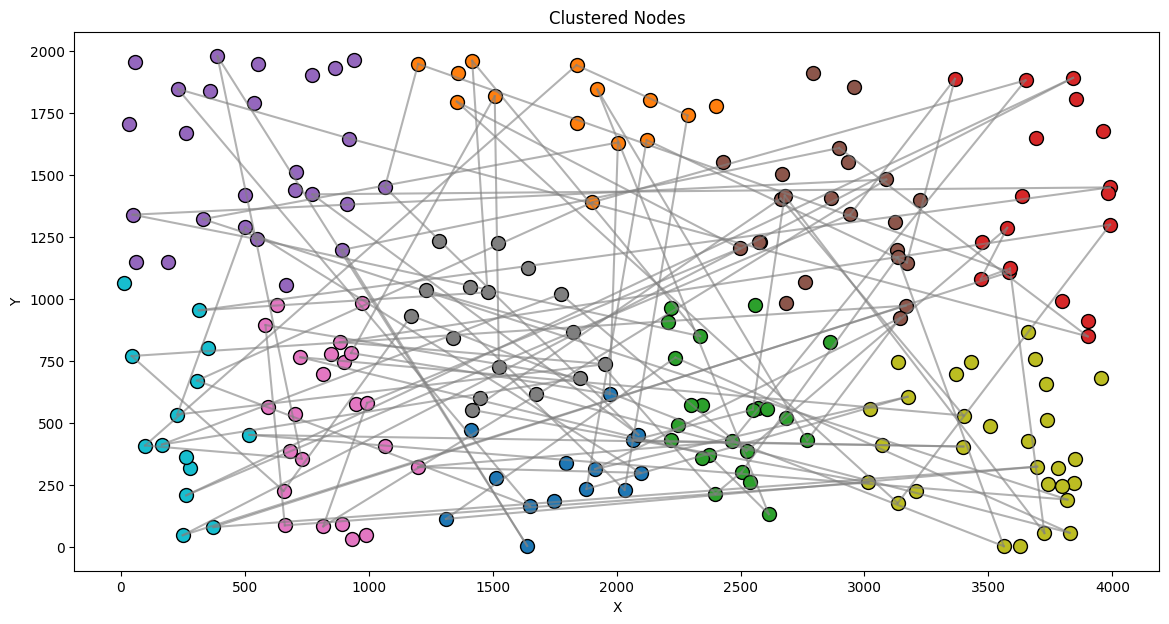

In [92]:
def plot_clusters(distance_matrix, weights, start_node):
    num_clusters=10
    coordinates = df[["x", "y"]].values
    kmeans = KMeans(n_clusters=num_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(coordinates)

    selected_nodes = []
    for cluster in range(num_clusters):
        cluster_indices = np.where(cluster_labels == cluster)[0]
        cluster_weights = weights[cluster_indices]
        sorted_indices = cluster_indices[np.argsort(cluster_weights)]
        selected_nodes.extend(sorted_indices[: max(1, 100 // num_clusters)])

    solution = list(np.random.choice(selected_nodes, 100, replace=False))
    # score = calculate_score(solution, distance_matrix, weights)

    plt.figure(figsize=(14, 7))
    num_clusters = len(set(cluster_labels))
    cmap = cm.get_cmap('tab10', num_clusters)

    for cluster in range(num_clusters):
        cluster_points = coordinates[cluster_labels == cluster]
        cluster_weights = weights[cluster_labels == cluster]
        plt.scatter(cluster_points[:, 0], cluster_points[:, 1], c=[cmap(cluster)], label=f'Cluster {cluster}', s=100, edgecolors='black')

    if solution is not None:
        for start, end in zip(solution[:-1], solution[1:]):
            plt.plot([df.x[start], df.x[end]], [df.y[start], df.y[end]], color='gray', alpha=0.6)
        plt.plot([df.x[solution[-1]], df.x[solution[0]]], [df.y[solution[-1]], df.y[solution[0]]], color='gray', alpha=0.6)

    # plt.colorbar(cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=0, vmax=num_clusters - 1)), label='Cluster')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title('Clustered Nodes')
    # plt.legend()
    plt.grid(False)
    plt.show()

# --- Example Usage ---
plot_clusters(distance_matrix, weights, 0)

In [55]:
ils_allowed_time = 97.98816983699798

In [56]:
# scores, solutions, iterations = test_many_ils(ILS, 20, distance_matrix, weights, change_weights_perturbation_big, low_weight_solution, deltas_steepest_local_search_edges, len(weights), ils_allowed_time)
# ils_names.append("change_weights_perturbation_big")
# ils_scores.append(scores)
# ils_solutions.append(solutions)
# ils_iterations.append(iterations)
# temp_scores = np.array(scores)
# print(f"Mean score: {temp_scores.mean()}")
# print(f"Min score: {temp_scores.min()}")
# best_arg = np.argmin(temp_scores)
# best_solution = solutions[best_arg]
# plot_nodes_with_lines(df, best_solution)
# print(best_solution)

In [57]:
# scores, solutions, iterations = test_many_ils(ILS, 20, distance_matrix, weights, change_coordinates_perturbation_very_small, low_weight_solution, deltas_steepest_local_search_edges, len(weights), ils_allowed_time)
# ils_names.append("change_coordinates_perturbation_very_small")
# ils_scores.append(scores)
# ils_solutions.append(solutions)
# ils_iterations.append(iterations)
# temp_scores = np.array(scores)
# print(f"Mean score: {temp_scores.mean()}")
# print(f"Min score: {temp_scores.min()}")
# best_arg = np.argmin(temp_scores)
# best_solution = solutions[best_arg]
# plot_nodes_with_lines(df, best_solution)
# print(best_solution)

In [58]:
# scores, solutions, iterations = test_many_ils(ILS, 20, distance_matrix, weights, change_coordinates_perturbation_big, low_weight_solution, deltas_steepest_local_search_edges, len(weights), ils_allowed_time)
# ils_names.append("change_coordinates_perturbation_big")
# ils_scores.append(scores)
# ils_solutions.append(solutions)
# ils_iterations.append(iterations)
# temp_scores = np.array(scores)
# print(f"Mean score: {temp_scores.mean()}")
# print(f"Min score: {temp_scores.min()}")
# best_arg = np.argmin(temp_scores)
# best_solution = solutions[best_arg]
# plot_nodes_with_lines(df, best_solution)
# print(best_solution)

In [59]:
# scores, solutions, iterations = test_many_ils(ILS, 20, distance_matrix, weights, change_coordinates_perturbation_medium, low_weight_solution, deltas_steepest_local_search_edges, len(weights), ils_allowed_time)
# ils_names.append("change_coordinates_perturbation_medium")
# ils_scores.append(scores)
# ils_solutions.append(solutions)
# ils_iterations.append(iterations)
# temp_scores = np.array(scores)
# print(f"Mean score: {temp_scores.mean()}")
# print(f"Min score: {temp_scores.min()}")
# best_arg = np.argmin(temp_scores)
# best_solution = solutions[best_arg]
# plot_nodes_with_lines(df, best_solution)
# print(best_solution)

In [60]:
# scores, solutions, iterations = test_many_ils(ILS, 20, distance_matrix, weights, change_coordinates_perturbation_small, low_weight_solution, deltas_steepest_local_search_edges, len(weights), ils_allowed_time)
# ils_names.append("change_coordinates_perturbation_small")
# ils_scores.append(scores)
# ils_solutions.append(solutions)
# ils_iterations.append(iterations)
# temp_scores = np.array(scores)
# print(f"Mean score: {temp_scores.mean()}")
# print(f"Min score: {temp_scores.min()}")
# best_arg = np.argmin(temp_scores)
# best_solution = solutions[best_arg]
# plot_nodes_with_lines(df, best_solution)
# print(best_solution)

In [61]:
# scores, solutions, iterations = test_many_ils(ILS, 20, distance_matrix, weights, shuffle_perturbation, low_weight_solution, deltas_steepest_local_search_edges, len(weights), ils_allowed_time)
# ils_names.append("shuffle_perturbation")
# ils_scores.append(scores)
# ils_solutions.append(solutions)
# ils_iterations.append(iterations)
# temp_scores = np.array(scores)
# print(f"Mean score: {temp_scores.mean()}")
# print(f"Min score: {temp_scores.min()}")
# best_arg = np.argmin(temp_scores)
# best_solution = solutions[best_arg]
# plot_nodes_with_lines(df, best_solution)
# print(best_solution)

In [62]:
# scores, solutions, iterations = test_many_ils(ILS, 20, distance_matrix, weights, partial_shuffle_perturbation_80, low_weight_solution, deltas_steepest_local_search_edges, len(weights), ils_allowed_time)
# ils_names.append("partial_shuffle_perturbation_80")
# ils_scores.append(scores)
# ils_solutions.append(solutions)
# ils_iterations.append(iterations)
# temp_scores = np.array(scores)
# print(f"Mean score: {temp_scores.mean()}")
# print(f"Min score: {temp_scores.min()}")
# best_arg = np.argmin(temp_scores)
# best_solution = solutions[best_arg]
# plot_nodes_with_lines(df, best_solution)
# print(best_solution)

In [63]:
# scores, solutions, iterations = test_many_ils(ILS, 20, distance_matrix, weights, partial_shuffle_perturbation_50, low_weight_solution, deltas_steepest_local_search_edges, len(weights), ils_allowed_time)
# ils_names.append("partial_shuffle_perturbation_50")
# ils_scores.append(scores)
# ils_solutions.append(solutions)
# ils_iterations.append(iterations)
# temp_scores = np.array(scores)
# print(f"Max score: {temp_scores.max()}")
# print(f"Mean score: {temp_scores.mean()}")
# print(f"Min score: {temp_scores.min()}")
# best_arg = np.argmin(temp_scores)
# best_solution = solutions[best_arg]
# plot_nodes_with_lines(df, best_solution)
# print(best_solution)

In [64]:
# scores, solutions, iterations = test_many_ils(ILS, 20, distance_matrix, weights, partial_shuffle_perturbation_50, low_weights_solution_ls, deltas_steepest_local_search_edges, len(weights), ils_allowed_time)
# ils_names.append("partial_shuffle_perturbation_50")
# ils_scores.append(scores)
# ils_solutions.append(solutions)
# ils_iterations.append(iterations)
# temp_scores = np.array(scores)
# print(f"Max score: {temp_scores.max()}")
# print(f"Mean score: {temp_scores.mean()}")
# print(f"Min score: {temp_scores.min()}")
# best_arg = np.argmin(temp_scores)
# best_solution = solutions[best_arg]
# plot_nodes_with_lines(df, best_solution)
# print(best_solution)

In [65]:
# scores, solutions, iterations = test_many_ils(ILS, 20, distance_matrix, weights, partial_shuffle_perturbation_20, low_weight_solution, deltas_steepest_local_search_edges, len(weights), ils_allowed_time)
# ils_names.append("partial_shuffle_perturbation_20")
# ils_scores.append(scores)
# ils_solutions.append(solutions)
# ils_iterations.append(iterations)
# temp_scores = np.array(scores)
# print(f"Max score: {temp_scores.max()}")
# print(f"Mean score: {temp_scores.mean()}")
# print(f"Min score: {temp_scores.min()}")
# best_arg = np.argmin(temp_scores)
# best_solution = solutions[best_arg]
# plot_nodes_with_lines(df, best_solution)
# print(best_solution)

Mean iterations 1407.65
Max score: 69720
Mean score: 69382.55
Min score: 69095


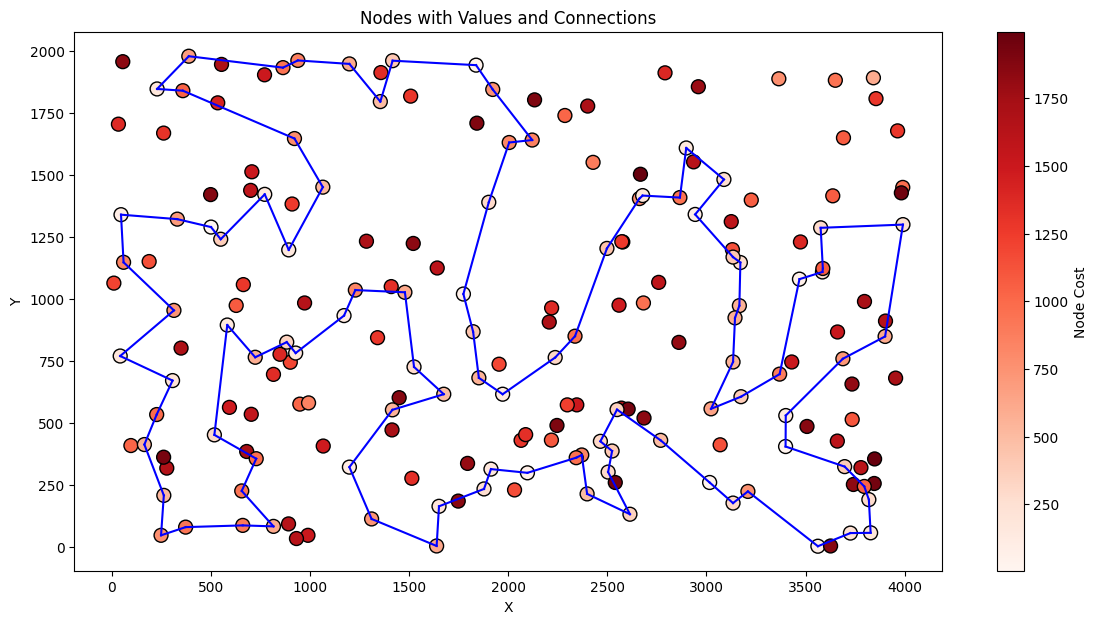

[18, 108, 140, 93, 117, 0, 143, 183, 89, 186, 23, 137, 176, 80, 79, 63, 94, 124, 148, 9, 62, 102, 144, 14, 49, 178, 106, 52, 55, 57, 129, 92, 179, 185, 40, 119, 165, 90, 81, 196, 145, 78, 31, 56, 113, 175, 171, 16, 25, 44, 120, 2, 152, 97, 1, 101, 75, 86, 26, 100, 53, 180, 154, 135, 70, 127, 123, 162, 133, 151, 51, 118, 59, 65, 116, 43, 42, 184, 35, 84, 112, 4, 190, 10, 177, 54, 48, 160, 34, 181, 146, 22, 159, 193, 41, 139, 115, 46, 68, 69]


In [66]:
scores, solutions, iterations = test_many_ils(ILS, 20, distance_matrix, weights, partial_shuffle_perturbation_20, cluster_based_selection, deltas_steepest_local_search_edges, len(weights), ils_allowed_time)
ils_names.append("partial_shuffle_perturbation_20")
ils_scores.append(scores)
ils_solutions.append(solutions)
ils_iterations.append(iterations)
temp_scores = np.array(scores)
print(f"Mean iterations {np.mean(iterations)}")
print(f"Max score: {temp_scores.max()}")
print(f"Mean score: {temp_scores.mean()}")
print(f"Min score: {temp_scores.min()}")
best_arg = np.argmin(temp_scores)
best_solution = solutions[best_arg]
plot_nodes_with_lines(df, best_solution)
print(best_solution)

Mean iterations 1533.5
Max score: 70047
Mean score: 69497.2
Min score: 69213


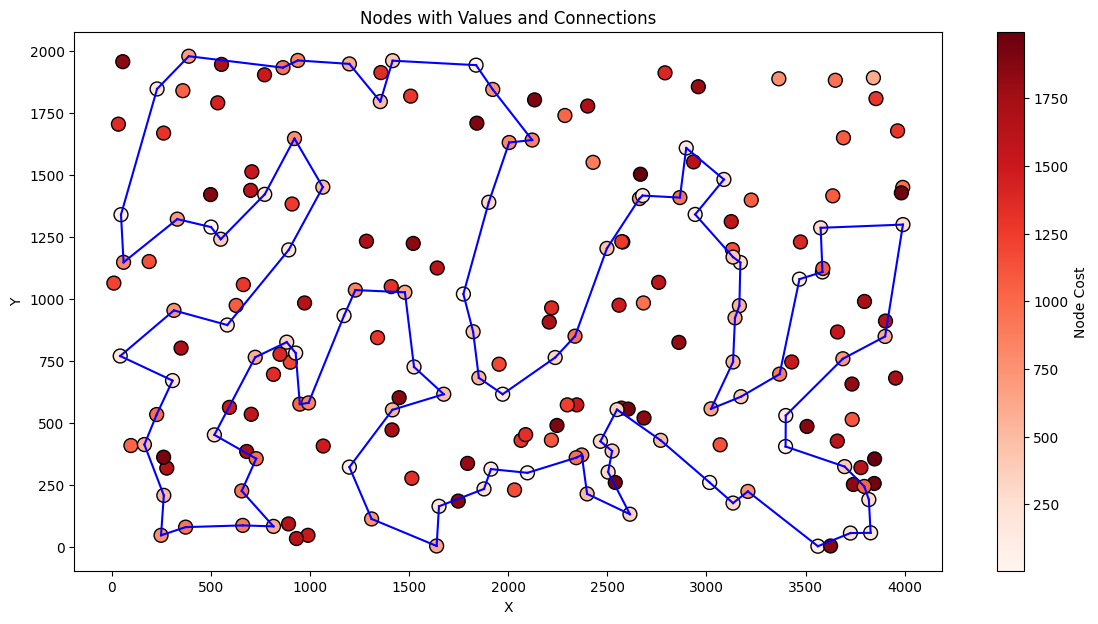

[62, 9, 148, 124, 94, 63, 79, 80, 176, 137, 23, 186, 89, 183, 143, 0, 117, 93, 140, 108, 18, 22, 146, 159, 193, 41, 139, 68, 46, 115, 42, 181, 34, 160, 48, 54, 177, 10, 190, 4, 112, 84, 35, 184, 43, 116, 65, 131, 149, 59, 118, 51, 151, 133, 162, 123, 127, 70, 135, 154, 180, 53, 100, 26, 86, 75, 101, 1, 97, 152, 2, 120, 44, 25, 16, 171, 175, 113, 56, 31, 78, 145, 196, 81, 90, 165, 40, 185, 179, 92, 129, 57, 55, 52, 106, 178, 49, 14, 144, 102]


In [67]:
scores, solutions, iterations = test_many_ils(ILS, 20, distance_matrix, weights, partial_shuffle_perturbation_20, biased_random_walk, deltas_steepest_local_search_edges, len(weights), ils_allowed_time)
ils_names.append("partial_shuffle_perturbation_20")
ils_scores.append(scores)
ils_solutions.append(solutions)
ils_iterations.append(iterations)
temp_scores = np.array(scores)
print(f"Mean iterations {np.mean(iterations)}")
print(f"Max score: {temp_scores.max()}")
print(f"Mean score: {temp_scores.mean()}")
print(f"Min score: {temp_scores.min()}")
best_arg = np.argmin(temp_scores)
best_solution = solutions[best_arg]
plot_nodes_with_lines(df, best_solution)
print(best_solution)

Mean iterations 1425.25
Max score: 70104
Mean score: 69546.6
Min score: 69219


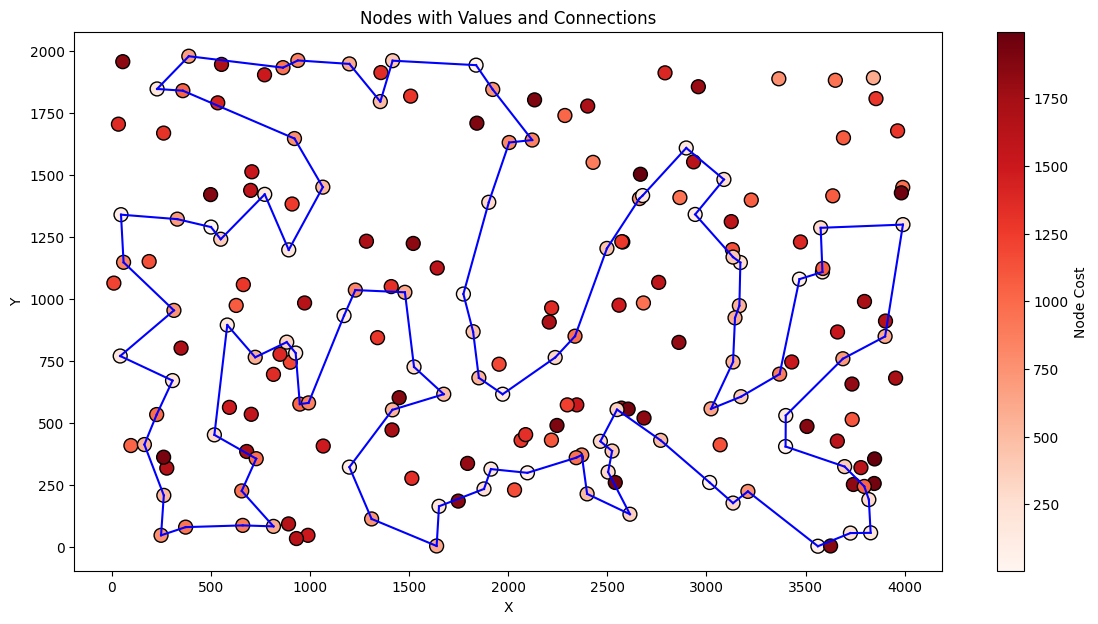

[84, 35, 184, 42, 43, 116, 65, 131, 149, 59, 118, 51, 151, 133, 162, 123, 127, 70, 135, 154, 180, 53, 100, 26, 86, 75, 101, 1, 97, 152, 2, 120, 44, 25, 16, 171, 175, 113, 56, 31, 78, 145, 196, 81, 90, 165, 40, 185, 179, 92, 129, 57, 55, 52, 106, 178, 49, 14, 144, 62, 9, 148, 124, 94, 63, 79, 80, 176, 137, 23, 186, 89, 183, 143, 0, 117, 93, 140, 108, 18, 69, 68, 46, 115, 139, 41, 193, 159, 22, 146, 181, 34, 160, 48, 54, 177, 10, 190, 4, 112]


In [68]:
scores, solutions, iterations = test_many_ils(ILS, 20, distance_matrix, weights, partial_shuffle_perturbation_20, weighted_probabilistic_selection, deltas_steepest_local_search_edges, len(weights), ils_allowed_time)
ils_names.append("partial_shuffle_perturbation_20")
ils_scores.append(scores)
ils_solutions.append(solutions)
ils_iterations.append(iterations)
temp_scores = np.array(scores)
print(f"Mean iterations {np.mean(iterations)}")
print(f"Max score: {temp_scores.max()}")
print(f"Mean score: {temp_scores.mean()}")
print(f"Min score: {temp_scores.min()}")
best_arg = np.argmin(temp_scores)
best_solution = solutions[best_arg]
plot_nodes_with_lines(df, best_solution)
print(best_solution)

Mean iterations 1487.8
Max score: 70298
Mean score: 69526.3
Min score: 69165


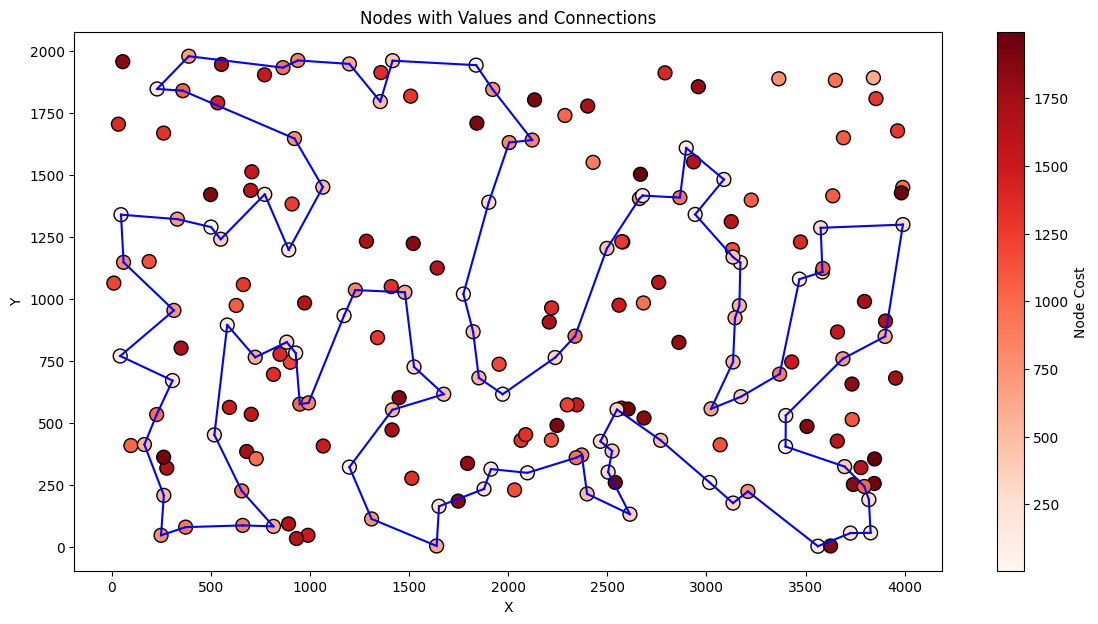

[146, 181, 34, 160, 48, 54, 177, 10, 190, 4, 112, 84, 184, 42, 43, 116, 65, 131, 149, 59, 118, 51, 151, 133, 162, 123, 127, 70, 135, 154, 180, 53, 100, 26, 86, 75, 101, 1, 97, 152, 2, 120, 44, 25, 16, 171, 175, 113, 56, 31, 78, 145, 196, 81, 90, 165, 40, 185, 179, 92, 129, 57, 55, 52, 106, 178, 49, 14, 144, 102, 62, 9, 148, 124, 94, 63, 79, 80, 176, 137, 23, 186, 89, 183, 143, 0, 117, 93, 140, 108, 18, 69, 68, 46, 115, 139, 41, 193, 159, 22]


In [69]:
scores, solutions, iterations = test_many_ils(ILS, 20, distance_matrix, weights, partial_shuffle_perturbation_20, grid_based_sampling, deltas_steepest_local_search_edges, len(weights), ils_allowed_time)
ils_names.append("partial_shuffle_perturbation_20")
ils_scores.append(scores)
ils_solutions.append(solutions)
ils_iterations.append(iterations)
temp_scores = np.array(scores)
print(f"Mean iterations {np.mean(iterations)}")
print(f"Max score: {temp_scores.max()}")
print(f"Mean score: {temp_scores.mean()}")
print(f"Min score: {temp_scores.min()}")
best_arg = np.argmin(temp_scores)
best_solution = solutions[best_arg]
plot_nodes_with_lines(df, best_solution)
print(best_solution)

Max score: 70329
Mean score: 69699.5
Min score: 69277


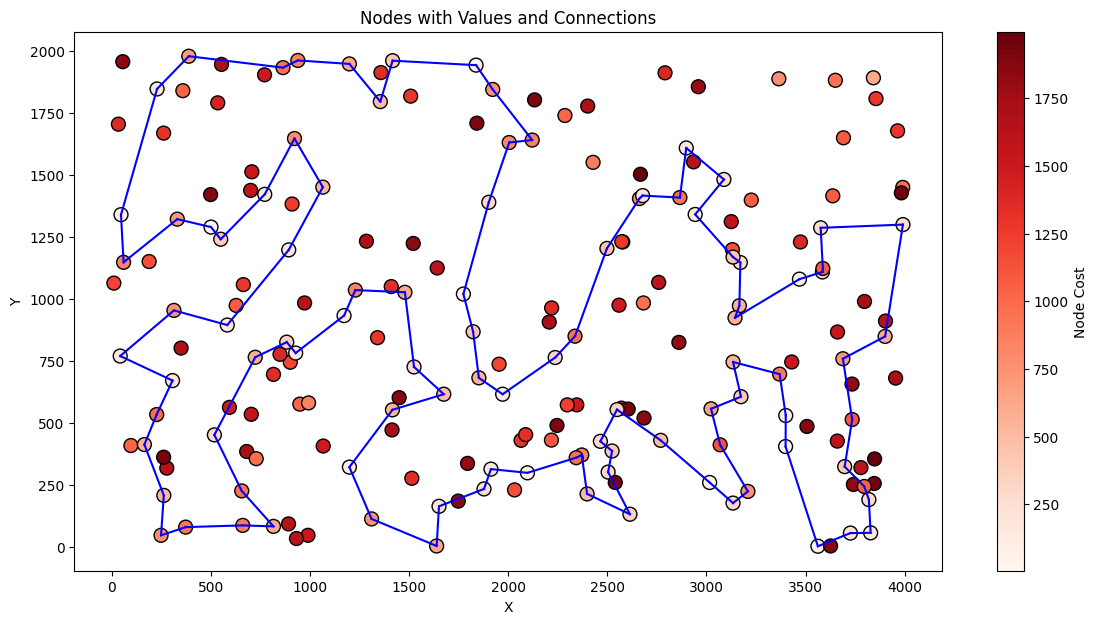

[175, 171, 16, 78, 145, 179, 57, 92, 129, 82, 25, 44, 120, 2, 152, 97, 1, 101, 75, 86, 26, 100, 53, 180, 154, 135, 70, 127, 123, 162, 133, 151, 51, 118, 59, 65, 116, 43, 184, 84, 112, 4, 190, 10, 177, 54, 48, 160, 34, 181, 42, 115, 46, 68, 139, 41, 193, 159, 146, 22, 18, 108, 140, 93, 117, 0, 143, 183, 89, 186, 23, 137, 176, 80, 79, 63, 94, 124, 148, 9, 62, 102, 144, 14, 49, 178, 106, 52, 55, 185, 40, 119, 165, 90, 81, 196, 157, 31, 56, 113]


In [31]:
# scores, solutions, iterations = test_many_ils(ILS, 20, distance_matrix, weights, partial_shuffle_perturbation_20, low_weights_solution_ls, deltas_steepest_local_search_edges, len(weights), ils_allowed_time)
# ils_names.append("partial_shuffle_perturbation_20")
# ils_scores.append(scores)
# ils_solutions.append(solutions)
# ils_iterations.append(iterations)
# temp_scores = np.array(scores)
# print(f"Max score: {temp_scores.max()}")
# print(f"Mean score: {temp_scores.mean()}")
# print(f"Min score: {temp_scores.min()}")
# best_arg = np.argmin(temp_scores)
# best_solution = solutions[best_arg]
# plot_nodes_with_lines(df, best_solution)
# print(best_solution)

Max score: 70051
Mean score: 69636.35
Min score: 69283


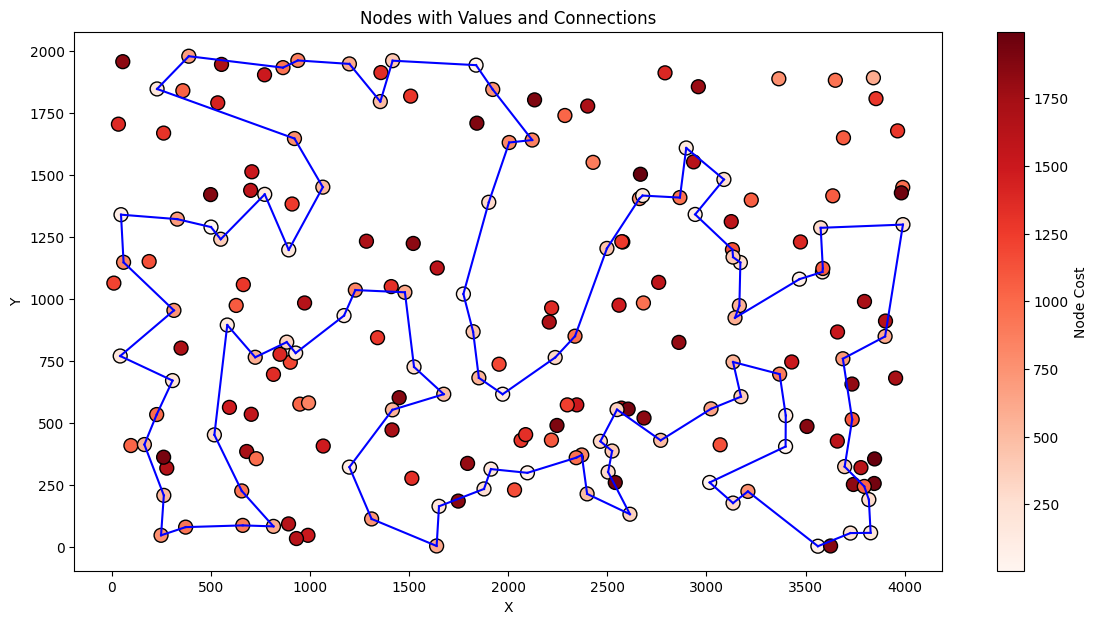

[159, 22, 146, 181, 34, 160, 48, 54, 177, 10, 190, 4, 112, 84, 184, 42, 43, 116, 65, 59, 118, 51, 151, 133, 162, 123, 127, 70, 135, 154, 180, 53, 100, 26, 86, 75, 101, 1, 97, 152, 2, 129, 92, 57, 179, 145, 78, 120, 44, 25, 16, 171, 175, 113, 56, 31, 157, 196, 81, 90, 165, 119, 40, 185, 55, 52, 106, 178, 3, 49, 14, 144, 102, 62, 9, 148, 124, 94, 63, 79, 80, 176, 137, 23, 186, 89, 183, 143, 0, 117, 93, 140, 108, 18, 68, 46, 115, 139, 41, 193]


In [32]:
# scores, solutions, iterations = test_many_ils(ILS, 20, distance_matrix, weights, partial_shuffle_perturbation_10, low_weight_solution, deltas_steepest_local_search_edges, len(weights), ils_allowed_time)
# ils_names.append("partial_shuffle_perturbation_10")
# ils_scores.append(scores)
# ils_solutions.append(solutions)
# ils_iterations.append(iterations)
# temp_scores = np.array(scores)
# print(f"Max score: {temp_scores.max()}")
# print(f"Mean score: {temp_scores.mean()}")
# print(f"Min score: {temp_scores.min()}")
# best_arg = np.argmin(temp_scores)
# best_solution = solutions[best_arg]
# plot_nodes_with_lines(df, best_solution)
# print(best_solution)

Max score: 70791
Mean score: 70169.0
Min score: 69485


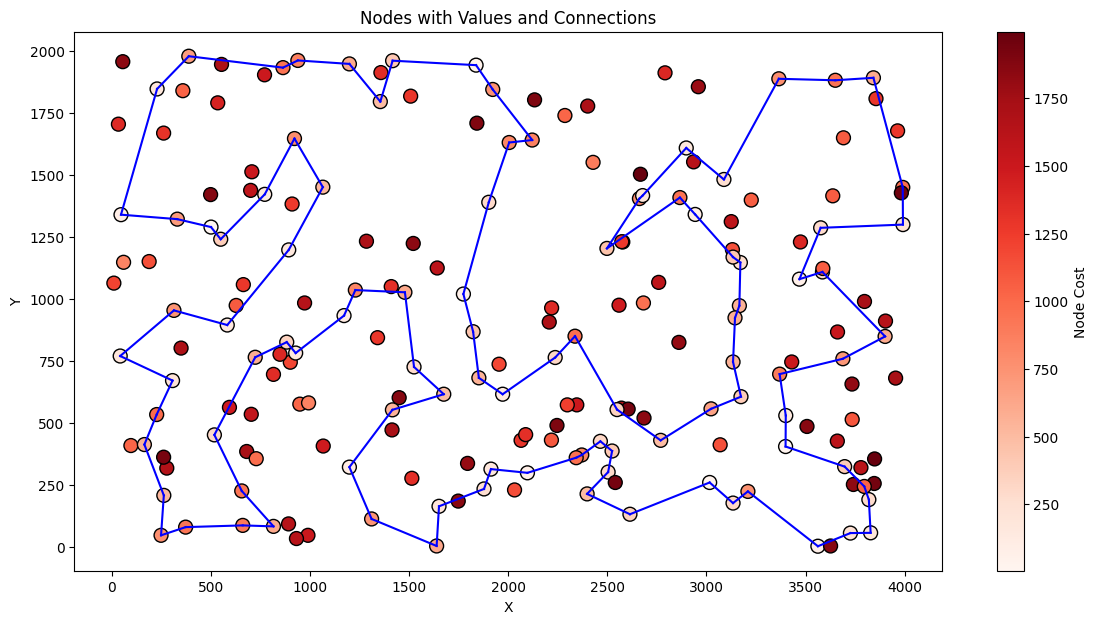

[102, 49, 178, 106, 52, 55, 57, 92, 129, 2, 152, 124, 94, 63, 79, 80, 176, 137, 23, 186, 89, 183, 143, 0, 117, 93, 140, 108, 18, 22, 159, 193, 41, 139, 68, 46, 115, 42, 181, 34, 160, 48, 54, 177, 10, 190, 4, 112, 84, 184, 43, 116, 65, 59, 118, 51, 151, 133, 162, 123, 127, 70, 135, 154, 180, 53, 100, 26, 97, 1, 101, 86, 75, 120, 44, 25, 16, 171, 175, 113, 56, 31, 78, 145, 179, 196, 81, 40, 185, 165, 90, 27, 164, 7, 21, 14, 144, 62, 9, 148]


In [33]:
# scores, solutions, iterations = test_many_ils(ILS, 20, distance_matrix, weights, partial_shuffle_perturbation_10, low_weights_solution_ls, deltas_steepest_local_search_edges, len(weights), ils_allowed_time)
# ils_names.append("partial_shuffle_perturbation_10")
# ils_scores.append(scores)
# ils_solutions.append(solutions)
# ils_iterations.append(iterations)
# temp_scores = np.array(scores)
# print(f"Max score: {temp_scores.max()}")
# print(f"Mean score: {temp_scores.mean()}")
# print(f"Min score: {temp_scores.min()}")
# best_arg = np.argmin(temp_scores)
# best_solution = solutions[best_arg]
# plot_nodes_with_lines(df, best_solution)
# print(best_solution)

In [34]:
# scores, solutions, iterations = test_many_ils(ILS, 20, distance_matrix, weights, switcheroo_perturbation, low_weight_solution, deltas_steepest_local_search_edges, len(weights), ils_allowed_time)
# ils_names.append("switcheroo_perturbation")
# ils_scores.append(scores)
# ils_solutions.append(solutions)
# ils_iterations.append(iterations)
# temp_scores = np.array(scores)
# print(f"Mean score: {temp_scores.mean()}")
# print(f"Min score: {temp_scores.min()}")
# best_arg = np.argmin(temp_scores)
# best_solution = solutions[best_arg]
# plot_nodes_with_lines(df, best_solution)
# print(best_solution)

In [35]:
# scores, solutions, iterations = test_many_ils(ILS, 20, distance_matrix, weights, mst_perturbation, low_weight_solution, deltas_steepest_local_search_edges, len(weights), ils_allowed_time)
# ils_names.append("mst_perturbation")
# ils_scores.append(scores)
# ils_solutions.append(solutions)
# ils_iterations.append(iterations)
# temp_scores = np.array(scores)
# print(f"Mean score: {temp_scores.mean()}")
# print(f"Min score: {temp_scores.min()}")
# best_arg = np.argmin(temp_scores)
# best_solution = solutions[best_arg]
# plot_nodes_with_lines(df, best_solution)
# print(best_solution)

## TSPB instance

In [70]:
df_B = pd.read_csv(TSPB_PATH, sep=";", header=None)
df_B.columns = ["x", "y", "val"]
distance_matrix_B = get_distance_matrix(df_B, euclidean_distance)
weights_B = df_B.val.to_numpy()
weights_B[:2]

array([ 40, 247], dtype=int64)

In [71]:
from sklearn.cluster import KMeans

def cluster_based_selection(distance_matrix, weights, start_node):
    num_clusters=10
    coordinates = df_B[["x", "y"]].values
    kmeans = KMeans(n_clusters=num_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(coordinates)

    selected_nodes = []
    for cluster in range(num_clusters):
        cluster_indices = np.where(cluster_labels == cluster)[0]
        cluster_weights = weights[cluster_indices]
        sorted_indices = cluster_indices[np.argsort(cluster_weights)]
        selected_nodes.extend(sorted_indices[: max(1, 100 // num_clusters)])

    solution = list(np.random.choice(selected_nodes, 100, replace=False))
    # print(solution)
    return solution, calculate_score(solution, distance_matrix, weights)

### Experiments

In [72]:
ils_B_names = []
ils_B_scores = []
ils_B_solutions = []
ils_B_iterations = []

Mean iterations 1430.25
Max score: 44493
Mean score: 43834.7
Min score: 43519


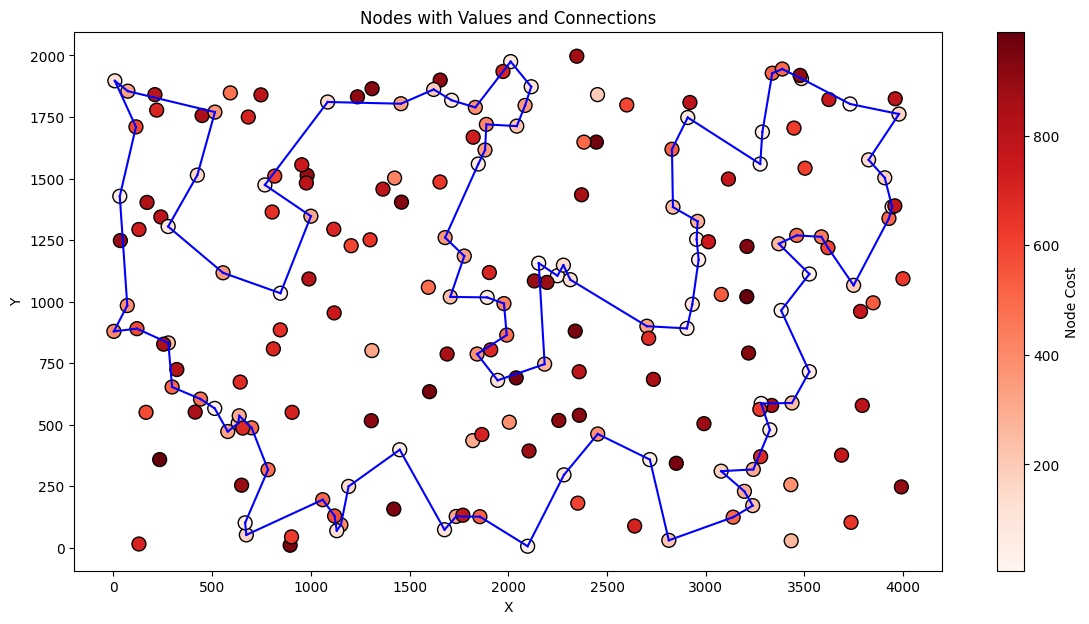

[135, 122, 133, 107, 40, 100, 63, 38, 27, 16, 1, 156, 198, 117, 193, 31, 54, 73, 136, 190, 80, 45, 142, 175, 78, 5, 177, 36, 61, 91, 141, 77, 81, 153, 187, 165, 127, 89, 163, 103, 113, 176, 194, 166, 86, 185, 95, 130, 99, 22, 179, 66, 94, 47, 148, 60, 20, 28, 149, 4, 140, 183, 152, 170, 34, 55, 18, 62, 124, 106, 143, 35, 109, 0, 29, 111, 8, 104, 144, 160, 33, 138, 11, 139, 168, 195, 13, 145, 15, 3, 70, 132, 169, 188, 6, 147, 90, 51, 121, 131]


In [77]:
scores, solutions, iterations = test_many_ils(ILS, 20, distance_matrix_B, weights_B, partial_shuffle_perturbation_20, cluster_based_selection, deltas_steepest_local_search_edges, len(weights_B), ils_allowed_time)
ils_B_names.append("partial_shuffle_perturbation_20")
ils_B_scores.append(scores)
ils_B_solutions.append(solutions)
ils_B_iterations.append(iterations)
temp_scores = np.array(scores)
print(f"Mean iterations {np.mean(iterations)}")
print(f"Max score: {temp_scores.max()}")
print(f"Mean score: {temp_scores.mean()}")
print(f"Min score: {temp_scores.min()}")
best_arg = np.argmin(temp_scores)
best_solution = solutions[best_arg]
plot_nodes_with_lines(df_B, best_solution)
print(best_solution)

Mean iterations 1438.7
Max score: 44623
Mean score: 43876.4
Min score: 43504


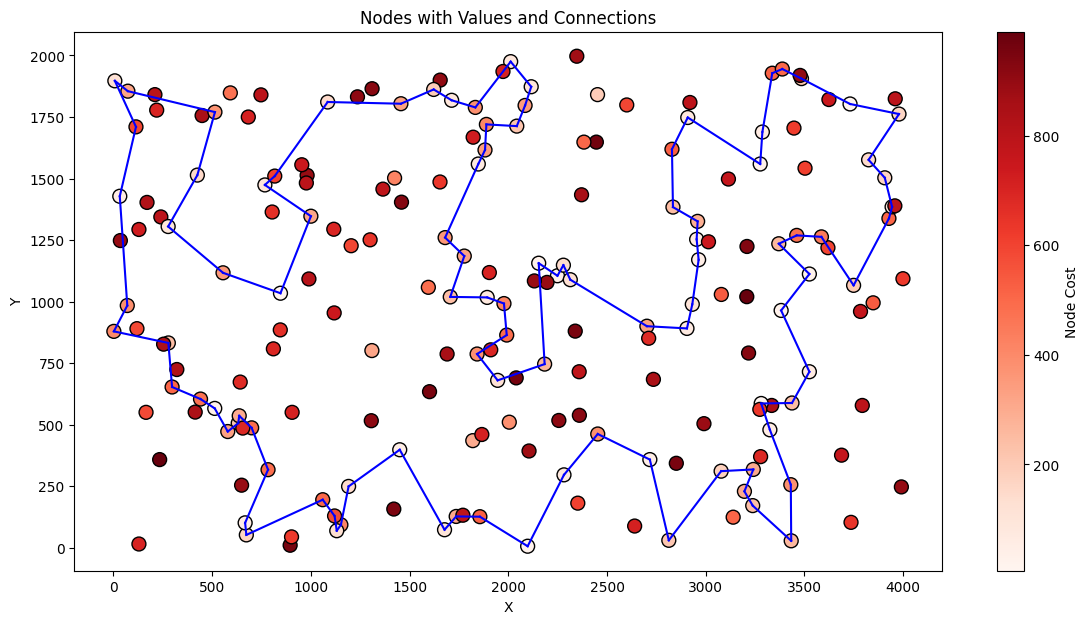

[38, 27, 1, 156, 198, 117, 193, 31, 54, 73, 136, 190, 80, 45, 142, 175, 78, 5, 177, 36, 61, 91, 141, 77, 81, 153, 187, 163, 103, 89, 127, 137, 114, 113, 176, 194, 166, 86, 185, 95, 130, 99, 179, 66, 94, 47, 148, 60, 20, 28, 149, 4, 140, 183, 152, 170, 34, 55, 18, 62, 124, 106, 143, 35, 109, 0, 29, 111, 8, 104, 144, 160, 33, 138, 11, 139, 168, 195, 13, 145, 15, 3, 70, 132, 169, 188, 6, 147, 191, 90, 51, 121, 131, 135, 122, 133, 107, 40, 100, 63]


In [76]:
scores, solutions, iterations = test_many_ils(ILS, 20, distance_matrix_B, weights_B, partial_shuffle_perturbation_20, cluster_based_selection, deltas_steepest_local_search_edges, len(weights_B), ils_allowed_time)
ils_B_names.append("partial_shuffle_perturbation_20")
ils_B_scores.append(scores)
ils_B_solutions.append(solutions)
ils_B_iterations.append(iterations)
temp_scores = np.array(scores)
print(f"Mean iterations {np.mean(iterations)}")
print(f"Max score: {temp_scores.max()}")
print(f"Mean score: {temp_scores.mean()}")
print(f"Min score: {temp_scores.min()}")
best_arg = np.argmin(temp_scores)
best_solution = solutions[best_arg]
plot_nodes_with_lines(df_B, best_solution)
print(best_solution)